# Comparison between Sentiment Classifiers

This repository concerns the comparative analysis between existing sentiment classifiers and a classifier that I built myself. The models that are analysed are:
-  Sentiment Neuron: a deep learning model developed by OpenAI; 
-  VADER Sentiment Analysis: a lexicon-based heuristic model;
-  NBSVM: a hybrid model that brings together Naive Bayes and Support Vector Machines (SVM), adapted from __[(Manning & Wang, 2012)](https://github.com/sidaw/nbsvm)__.

Three chosen models were tested on the Twitter corpus that I collected. This corpus consists of 70 pos/neg/neu tweets (210 in total) from UK published withing June - November 2018. The corpus is available in the current repository.

In [9]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [3]:
import nbsvm2

In [4]:
nlp = spacy.load('en_core_web_sm')

## Sentiment Neuron

Firstly, let's load the test corpus.

In [4]:
tweets = pd.read_csv('Tweets - New set.tsv', sep='\t', header=0)
corpus = tweets[['Tweets','Sentiment']]

The prerequisited to run this model can be seen at the __[model website](https://modeldepot.io/afowler/sentiment-neuron)__.

In [6]:
from encoder import Model

model = Model()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
dim is deprecated, use axis instead


In [7]:
text_features = model.transform(corpus['Tweets'])

65.002 seconds to transform 210 examples


In [8]:
score = text_features[:, 2388]
corpus['SN'] = score

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
pd.options.display.max_colwidth = 200

In [11]:
corpus

,Tweets,Sentiment,SN
0,The roads are quite bad x,neg,-0.152479
1,"Bridesmaids is actually quite poor, disappointed",neg,-1.007007
2,Doctors is so bad its actually quite terrible,neg,-0.934712
3,The end sequence is really quite good,pos,0.255769
4,Everyone was placed together on one table so it was quite nice x,pos,0.407855
5,Wish I was still playing beer pong in the sun! Why is the British weather so terrible,neg,0.113525
6,Always seems to be something to put me in a bad mood,neg,-0.052265
7,"My dreams are so awful at the moment, they're actually putting me off going to sleep. Why 😭",neg,-0.197482
8,"Thousand Autumns ... is my favourite, (best of a very good bunch). Fantastic book",pos,1.196892
9,The snacks look very good! We can’t wait to tuck in! #uxtailsoup,pos,0.678580


In [12]:
min(corpus['SN'])

-1.7710530757904053

In [13]:
max(corpus['SN'])

1.4637116193771362

We are going to apply the thresholds from SentiVADER to convert Sentiment Neuron scale to trinary output. 
The thresholds are:
  - negative: <= -0.05;
  - neutral: -0.05 < tweet < 0.05;
  - positive: >= 0.05.
  

In [18]:
def interval(row):
    if row >= 0.05:
        val = 'pos'
    elif row <= -0.05:
        val = 'neg'
    else:
        val = 'neu'
    return val

In [19]:
corpus['SN_tri'] = corpus['SN'].map(interval)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Visualisations

Let's compare the true labels of the test set with the Sentiment Neuron trinary output converted from a scale. 

In [15]:
print(classification_report(corpus['Sentiment'], corpus['SN_tri'], target_names=['neg', 'neu', 'pos']))

             precision    recall  f1-score   support

        neg       0.71      0.76      0.73        70
        neu       0.61      0.16      0.25        70
        pos       0.60      1.00      0.75        70

avg / total       0.64      0.64      0.58       210



In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#cmap=plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [18]:
cnf_matrix = confusion_matrix(corpus['Sentiment'], corpus['SN_tri'])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[53  7 10]
 [22 11 37]
 [ 0  0 70]]


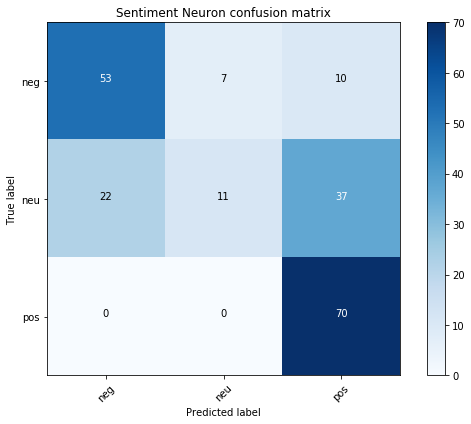

In [19]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['neg', 'neu', 'pos'],
                      title='Sentiment Neuron confusion matrix')

Let's draw a fine-grained plot where the scale is split into 5 different categories: exteremely negative - negative - neutral - positive - extremely positive. 

In [28]:
def detailed_scale(row):
    if row >= 1:
        val = 'very pos'
    elif row < 1 and row >= 0.05:
        val = 'pos'
    elif row < 0.05 and row > -0.05:
        val = 'neu'
    elif row <= -0.05 and row > -1:
        val = 'neg'
    elif row <= -1:
        val = 'very neg'
    return val

In [29]:
corpus['SN_labels'] = corpus['SN'].map(detailed_scale)

In [30]:
list_ordering = ['very neg', 'neg', 'neu', 'pos', 'very pos']
corpus["SN_labels"] = pd.Categorical(corpus["SN_labels"], categories=list_ordering, ordered=True) 

In [31]:
list_ordering = ['neg', 'neu', 'pos']
corpus["Sentiment"] = pd.Categorical(corpus["Sentiment"], categories=list_ordering, ordered=True) 

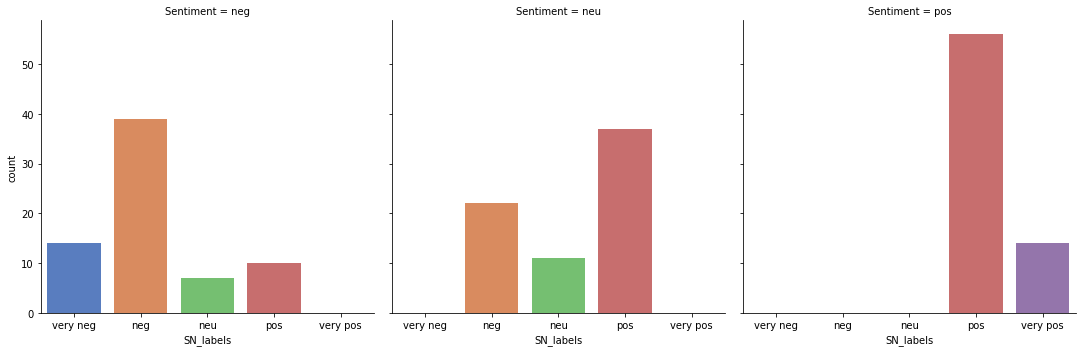

In [32]:
g = sns.catplot(x="SN_labels", col="Sentiment", col_wrap=3, data=corpus, 
                kind="count", palette='muted')

1. As far as the confusion matrix is concerned, all of the positive examples were correctly classified by Sentiment Neuron. The category that was confused the most is neutral. This result can be explained by the fact that it is hard to find tweets that are **absolutely** neutral without any flavour of sentiment. Negative tweets were confused with neutral and positive tweets. Neg-neu confusion is more intuitive, since these are borderline cases on a scale that were arbitrarily splitted into two categarories. Neg-pos confusion is more severe, as it concerns the tweets that were mistakenly put on the two different edges of the scale.
2. If we compare the discrete labelling to the scale, we can see that the negative category is mostly spread across different labels: there are negative tweets that are misclassified as neutral and negative. Luckily, the classifier error doesn't spread to the extremes of the scale: there are no negative tweets on the 'very positive' end of the scale. In addition, missclassification of the neutral tweets covers only nearby segments of the scale: negative and positive. 

Since the neg-pos missclassification is more severe, let's take a look at the negative tweets that were mistakenly put into neutral and positive categories and compate them.

In [33]:
# Neg-neu:
corpus[(corpus['Sentiment'] == 'neg') & (corpus['SN_tri'] == 'neu')][['Tweets', 'SN']]

,Tweets,SN
11,I hope my insomnia goes away tonight. I don't fancy being awake at 4am again.,0.010413
12,"I don’t like people who sugar coat things. Say it how it is, or don’t say anything at all. Move away with that pussy ass energy.",-0.047880
168,Honestly feel like shit Cba,0.047477
190,my skin is very bad help xx,-0.041637
192,If I get sleep paralysis again tonight I’m probs gonna kill myself cause I can’t deal with that shit,-0.043200
194,Huddersfield were shit as well to be honest,0.016877
195,"This is going to be controversial, but it's the truth. You choose your sides, choose who you ally with. Those racist, lowlife scum who burned a cardboard Grenfell will be Brexiters. Of that I've n...",0.036768


In [34]:
# Neg-pos:
corpus[(corpus['Sentiment'] == 'neg') & (corpus['SN_tri'] == 'pos')][['Tweets', 'SN']]

,Tweets,SN
5,Wish I was still playing beer pong in the sun! Why is the British weather so terrible,0.113525
149,I’m having a shit week and I just want to go back to bed🙄😒,0.431076
150,Going gym without headphones is fucking horrible,0.117610
151,Having to wait till payday for a trim is the worst🤧🤧🤧🤧,0.824278
152,Grief after someone very close to you dies is the most painful thing in the world. It makes all other problems you have been through feel so small and irrelevant.,0.290916
179,whenever i wake up and have no notifications i know my day is going to be awful,0.050017
181,finally getting more confident with my skin & the past few days i’ve been waking up with the worst breakouts😢,0.261675
184,"All for fireworks but why can’t they make them without the noise, my dogs are so scared it’s horrible to see my babies this way😩☹️",0.090688
204,Just cried watching that video of those fuckfaces burning a grenfell tower effigy. Psychopaths. Heartbroken and utterly disgusted by what our species is capable of.😰,0.305518
207,Some people really are pathetic 🤦🏻‍♀️,0.572178


One distinction that can be drawn is that 6/10 negative tweets that were classified as positive have emoticons. Since Sentiment Neuron was trained on the Amazon review dataset and tested on the Imdb review dataset, it was not largely exposed to emoticons. If we test the classifier on the same corpus with emoticons removed, will the performance improve?

In [37]:
no_emo = pd.read_csv('test_corpus_no_emo.tsv', sep='\t', header=0)

In [38]:
text_features = model.transform(no_emo['text'])
score = text_features[:, 2388]
no_emo['SN'] = score
no_emo['SN_tri'] = no_emo['SN'].map(interval)
print(classification_report(no_emo['label'], no_emo['SN_tri'], target_names=['neg', 'neu', 'pos']))
cnf_matrix = confusion_matrix(no_emo['label'], no_emo['SN_tri'])
np.set_printoptions(precision=2)

45.001 seconds to transform 210 examples
             precision    recall  f1-score   support

        neg       0.62      0.77      0.69        70
        neu       0.48      0.17      0.25        70
        pos       0.63      0.89      0.74        70

avg / total       0.58      0.61      0.56       210



Confusion matrix, without normalization
[[54 10  6]
 [28 12 30]
 [ 5  3 62]]


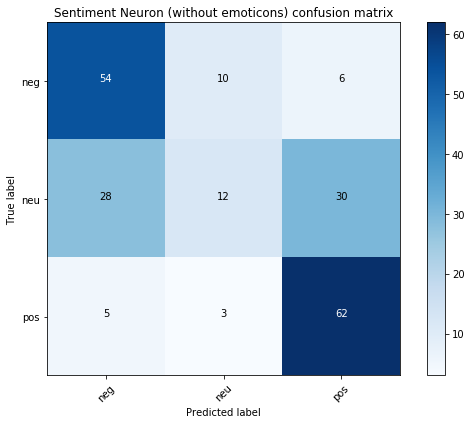

In [41]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['neg', 'neu', 'pos'],
                      title='Sentiment Neuron (without emoticons) confusion matrix')

In [42]:
no_emo['SN_labels'] = no_emo['SN'].map(detailed_scale)
list_ordering = ['very neg', 'neg', 'neu', 'pos', 'very pos']
no_emo["SN_labels"] = pd.Categorical(no_emo["SN_labels"], categories=list_ordering, ordered=True)
list_ordering = ['neg', 'neu', 'pos']
no_emo["label"] = pd.Categorical(no_emo["label"], categories=list_ordering, ordered=True) 

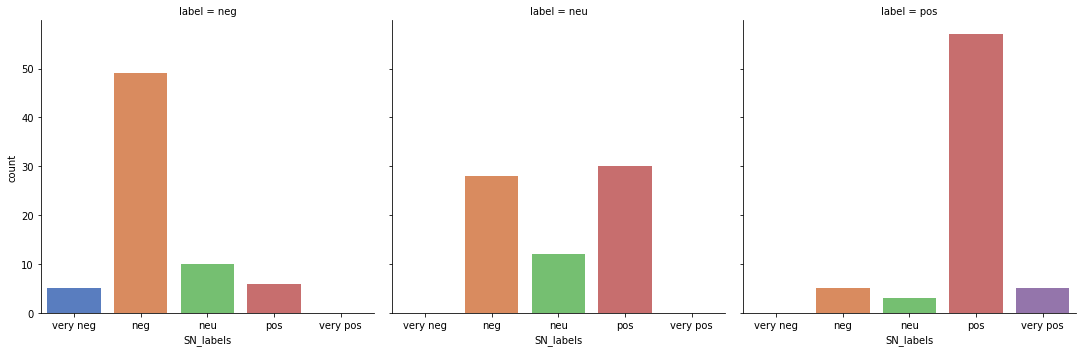

In [44]:
g = sns.catplot(x="SN_labels", col="label", col_wrap=3, data=no_emo, 
                kind="count", palette='muted')

The performance of the classifier descreased. The preprocessed stripped from emoticons texts might interfere with the inner preprocessing module which is built into Sentiment Neuron. 

## Sentiment VADER

Let's draw the same visualizations for the Sentiment VADER classifier.

The model's requirements and description can be foun in the following __[GitHub repository](https://github.com/cjhutto/vaderSentiment)__.

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [26]:
analyzer = SentimentIntensityAnalyzer()
SV_score = [analyzer.polarity_scores(t)['compound'] for t in corpus['Tweets']]

In [27]:
corpus['SV'] = SV_score

In [28]:
def s(row):
    if row['SV'] >= 0.05:
        val = 'pos'
    elif row['SV'] <= -0.05:
        val = 'neg'
    else:
        val = 'neu'
    return val

In [29]:
corpus['SV_tri'] = corpus.apply(s, axis=1)

In [30]:
print(classification_report(corpus['Sentiment'], corpus['SV_tri'], target_names=['neg', 'neu', 'pos']))

             precision    recall  f1-score   support

        neg       0.81      0.86      0.83        70
        neu       0.79      0.21      0.34        70
        pos       0.56      0.93      0.70        70

avg / total       0.72      0.67      0.62       210



In [31]:
cnf_matrix = confusion_matrix(corpus['Sentiment'], corpus['SV_tri'])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[60  2  8]
 [11 15 44]
 [ 3  2 65]]


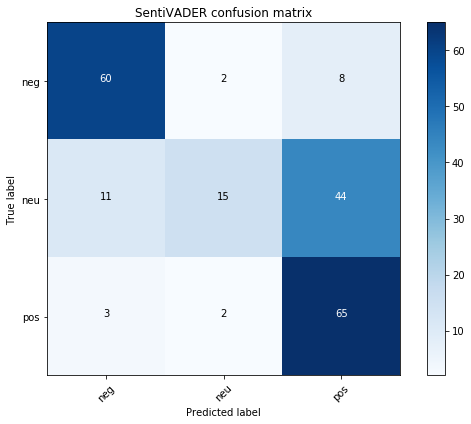

In [32]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['neg', 'neu', 'pos'],
                      title='SentiVADER confusion matrix')

In [33]:
def intervals(row):
    if row['SV'] >= 0.6:
        val = 'very pos'
    elif row['SV'] < 0.6 and row['SV'] >= 0.05:
        val = 'pos'
    elif row['SV'] < 0.05 and row['SV'] > -0.05:
        val = 'neu'
    elif row['SV'] <= -0.05 and row['SV'] > -0.6:
        val = 'neg'
    elif row['SV'] <= -0.6:
        val = 'very neg'
    return val

In [97]:
min(corpus['SV'])

-0.9466

In [34]:
corpus['SV_labels'] = corpus.apply(intervals, axis=1)

In [35]:
list_ordering = ['very neg', 'neg', 'neu', 'pos', 'very pos']
corpus["SV_labels"] = pd.Categorical(corpus["SV_labels"], categories=list_ordering, ordered=True) 

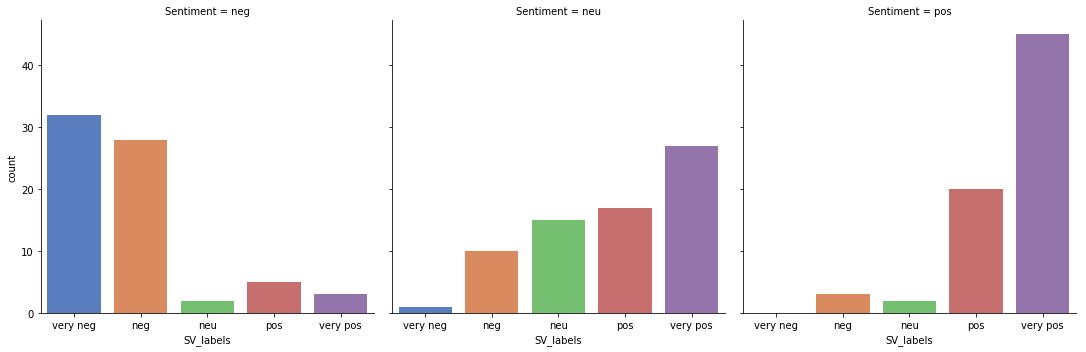

In [36]:
g = sns.catplot(x="SV_labels", col="Sentiment", col_wrap=3, data=corpus, 
                kind="count", palette='muted')

In [131]:
corpus.to_csv('cont_output_res.csv', index=False)

## Training my own model

### Preparing data

The training dataset was collected from different sources:
  - __[The Twitter Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/home)__ - a collection of tweets where the sentiment towards six US airline is expressed (trinary labelling).
  - __[The GOP Debate dataset](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)__ - a collection of tweets related to the Republican Party debate in Ohio (2016). Human annotators were asked to determine the sentiment of tweets (trinary labelling). 
  - __[The Weather Sentiment dataset](https://data.world/crowdflower/weather-sentiment)__ -  a collection of tweets about the weather. Annotators evalueted those tweets with neg/neu/pos labels. 
  - __[The Twitter Sentiment dataset](https://www.kaggle.com/rabinandan/twitter-sentiment)__ - a corpus of tweets collected and annotated by the Kaggle competition enthusiast.

The source data is included to the repository together with the concatinated dataset with unified labelling system that can be directly inputted to the model pipeline. 

The implementation of NB-SVM that is used in my report is adapted from __[Luis Rei's repository](https://github.com/lrei/nbsvm)__. Before running the model the texts should be preprocessed: they should lemmatized, stop words and emoticons are stripped. 

## Lemmatizing the collected corpus

Besides lemmatization, stop words and emoticons were stripped.

In [48]:
def lemmatization(text):
    row = text['Tweets']
#     print(type(row))
#     print(row)
    #row = text
    row = row.replace("\r","")
    row = row.replace("\n","")
    row = row.replace('RT', '')
    new_text = [token.lemma_ for token in nlp(row) if token.lemma_ != '-PRON-' and token.is_stop == False and token.pos_ != 'SYM' and token.pos_ != 'PUNCT' and not token.text.startswith('#')
               and token.text.isalpha()]
    return ' '.join(new_text)

In [85]:
string = 'Guess another severe #Thunderstorm is heading toward #WV. ❤️❤️❤️❤️ \n#NoMoreRain'
lemmatization(string)

'guess severe thunderstorm head wv nomorerain'

Unfortunately, the stacked dataset is highle unbalanced. Hence, some negative and neutral tweets were randomly omitted.

In [5]:
train = pd.read_csv('train_corpus.tsv', sep='\t', header=0)

In [6]:
test = pd.read_csv('test_corpus_no_emo.tsv', sep='\t', header=0)

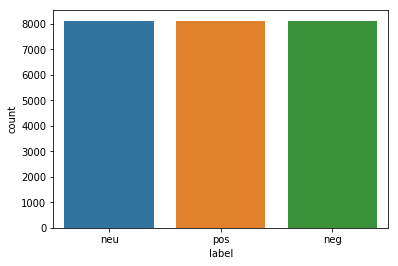

In [53]:
balance = sns.countplot(x="label", data=train)

Training different classifier configurations on our data. The training corpus is the stacked dataset described above. The test corpus - is the collection of tweets that was used for Sentiment Neuron and SentiVADER classfiers.

In [7]:
def pipeline_function(n_gram, classifier):
    # binary=True for the NBSVM model
    pipeline = Pipeline([
              ('vect', CountVectorizer(ngram_range=(1, n_gram), binary=False, token_pattern=r"\S+")),
              ('clf',   classifier)
      ])
    model = pipeline.fit(train['text'].values.astype('U'), train['label'])
    pred = model.predict(test['text'].values.astype('U'))
    print(classification_report(test['label'], pred, target_names=['neg', 'neu', 'pos']))
    cnf_matrix = confusion_matrix(test['label'], pred)
    np.set_printoptions(precision=2)
    return cnf_matrix

In [63]:
# NB-SVM trained on the unigram matrix
results_NBSVM1 = pipeline_function(1, nbsvm2.NBSVM())

             precision    recall  f1-score   support

        neg       0.60      0.84      0.70        70
        neu       0.50      0.21      0.30        70
        pos       0.62      0.73      0.67        70

avg / total       0.57      0.60      0.56       210



Confusion matrix, without normalization
[[59  5  6]
 [30 15 25]
 [ 9 10 51]]


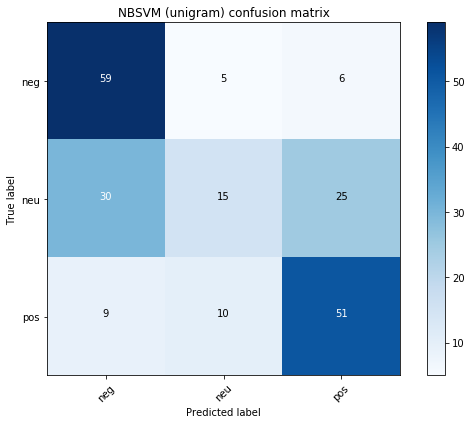

In [64]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NBSVM1, classes=['neg', 'neu', 'pos'],
                      title='NBSVM (unigram) confusion matrix')

In [65]:
# NB-SVM trained on the unigram+bigram matrix
results_NBSVM2 = pipeline_function(2, nbsvm2.NBSVM())

             precision    recall  f1-score   support

        neg       0.57      0.63      0.60        70
        neu       0.51      0.30      0.38        70
        pos       0.67      0.89      0.77        70

avg / total       0.59      0.60      0.58       210



Confusion matrix, without normalization
[[44 16 10]
 [29 21 20]
 [ 4  4 62]]


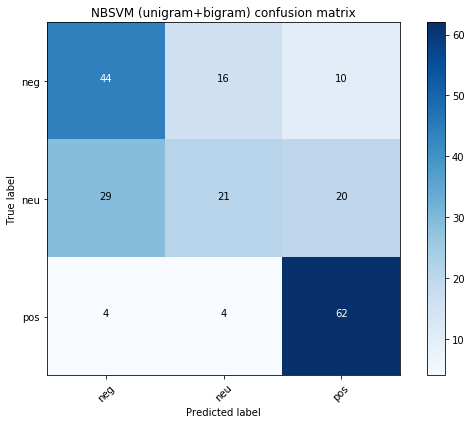

In [66]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NBSVM2, classes=['neg', 'neu', 'pos'],
                      title='NBSVM (unigram+bigram) confusion matrix')

In [67]:
# NB-SVM trained on the unigram+bigram+trigram matrix
results_NBSVM3 = pipeline_function(3, nbsvm2.NBSVM())

             precision    recall  f1-score   support

        neg       0.58      0.64      0.61        70
        neu       0.53      0.30      0.38        70
        pos       0.67      0.89      0.76        70

avg / total       0.59      0.61      0.58       210



Confusion matrix, without normalization
[[45 15 10]
 [28 21 21]
 [ 4  4 62]]


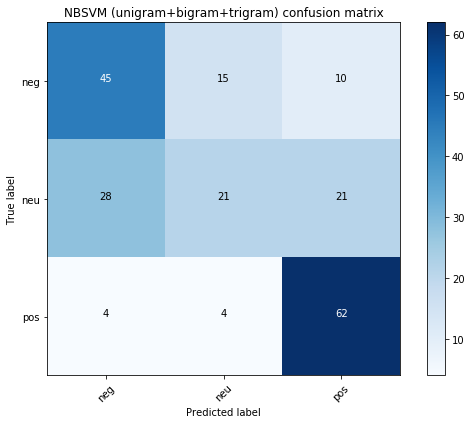

In [68]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NBSVM3, classes=['neg', 'neu', 'pos'],
                      title='NBSVM (unigram+bigram+trigram) confusion matrix')

I am going to run a multinomial Naive Bayes classifier for the sake of comparison.

In [71]:
# NB trained on the unigram matrix
results_NB1 = pipeline_function(1, MultinomialNB())

             precision    recall  f1-score   support

        neg       0.66      0.83      0.73        70
        neu       0.93      0.39      0.55        70
        pos       0.74      0.99      0.85        70

avg / total       0.78      0.73      0.71       210



Confusion matrix, without normalization
[[58  2 10]
 [29 27 14]
 [ 1  0 69]]


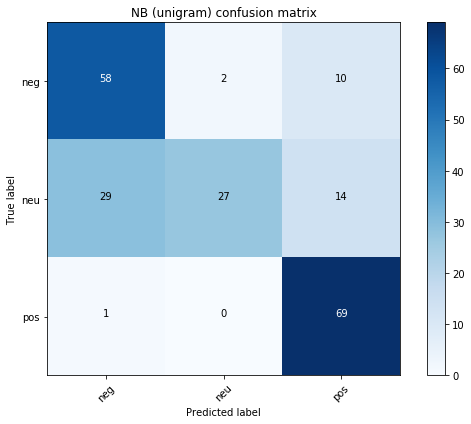

In [73]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NB1, classes=['neg', 'neu', 'pos'],
                      title='NB (unigram) confusion matrix')

In [74]:
# NB trained on the unigram+bigram matrix
results_NB2 = pipeline_function(2, MultinomialNB())

             precision    recall  f1-score   support

        neg       0.64      0.81      0.72        70
        neu       0.88      0.30      0.45        70
        pos       0.71      0.99      0.83        70

avg / total       0.74      0.70      0.66       210



Confusion matrix, without normalization
[[57  3 10]
 [31 21 18]
 [ 1  0 69]]


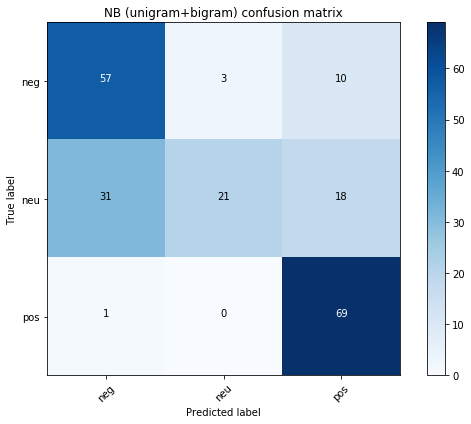

In [77]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NB2, classes=['neg', 'neu', 'pos'],
                      title='NB (unigram+bigram) confusion matrix')

In [76]:
# NB trained on the unigram+bigram+trigram matrix
results_NB3 = pipeline_function(3, MultinomialNB())

             precision    recall  f1-score   support

        neg       0.64      0.81      0.72        70
        neu       0.88      0.30      0.45        70
        pos       0.71      0.99      0.83        70

avg / total       0.74      0.70      0.66       210



Confusion matrix, without normalization
[[57  3 10]
 [31 21 18]
 [ 1  0 69]]


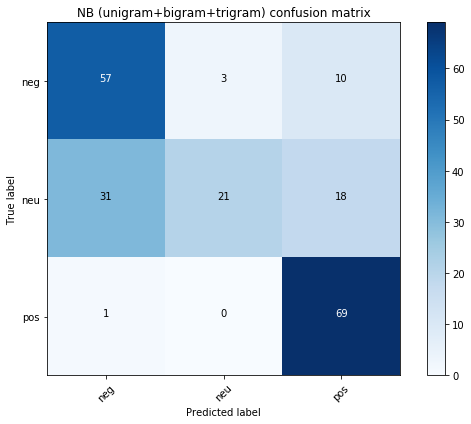

In [78]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_NB3, classes=['neg', 'neu', 'pos'],
                      title='NB (unigram+bigram+trigram) confusion matrix')

In [10]:
#SVM uni
results_SVM1 = pipeline_function(1, LinearSVC())

             precision    recall  f1-score   support

        neg       0.66      0.87      0.75        70
        neu       0.72      0.33      0.45        70
        pos       0.72      0.89      0.79        70

avg / total       0.70      0.70      0.67       210



Confusion matrix, without normalization
[[61  6  3]
 [26 23 21]
 [ 5  3 62]]


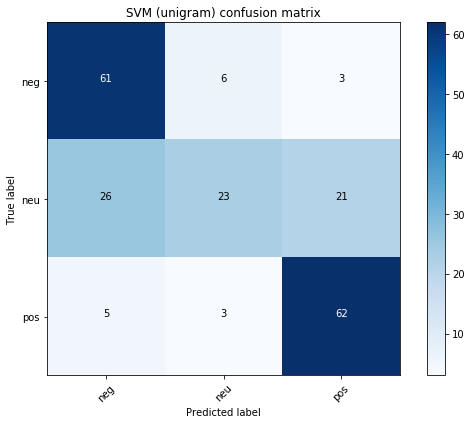

In [12]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_SVM1, classes=['neg', 'neu', 'pos'],
                      title='SVM (unigram) confusion matrix')

In [13]:
#SVM uni+bi
results_SVM2 = pipeline_function(2, LinearSVC())

             precision    recall  f1-score   support

        neg       0.69      0.87      0.77        70
        neu       0.77      0.33      0.46        70
        pos       0.70      0.91      0.80        70

avg / total       0.72      0.70      0.67       210



Confusion matrix, without normalization
[[61  5  4]
 [24 23 23]
 [ 4  2 64]]


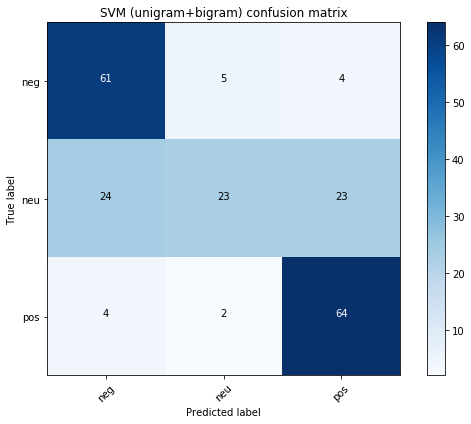

In [14]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(results_SVM2, classes=['neg', 'neu', 'pos'],
                      title='SVM (unigram+bigram) confusion matrix')